# Advanced Topics in Deep Learning

### Audio Classification

Data Description:
The dataset is from a popular dataset called UrbanSound8k, it contains 8732 labelled sound files which are less than or equal to 4 seconds in length. The audio wav files contains some common sounds that can be heard in an urban environment. 
It has 10 classes namely: 

Air conditioner, Car horn, Children playing, Dog barking, Drilling, Idle engine, Gun shot, Jack hammer, Siren, Street music. 

All recordings are taken from field recordings and the files are pre-sorted into ten folders

The problem I will be solving in this notebook is a supervised learning problem, I have a set of labeled data whose corresponding features would be extracted using MFCC. The label contains 10 different classes this makes it a multi label classification problem.The aim of this work is to build a model that can detect different kind of sounds in an environment (In this project it is limited to 10 sounds)

## Exploratory Data Analysis

### Meta Data Files

The audio dataset comes with a csv file that contains the meta-data information about every audio file in the dataset. I will first go through the meta data to have a good understanding of how the dataset is represented.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import IPython.display as ipd
import librosa.display
import os
# JUPYTER NOTEBOOK ONLY
%matplotlib inline

In [2]:
df = pd.read_csv('./data.csv')

In [3]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


Slice_file_name: contains the filename of each audio

fsID: The sound ID of the recording.

start: The start time of the slice.

end: The end time of the slice.

salience: a subjective salience rating of the sound. 1=foreground, 2=background.

fold: The fold number (1-10) to which this file has been allocated.

classID: a numeric identifier of the sound class:

Class: The class name



In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB


There are a total 8732 audio and 8 Column, also all the audio dataset are well represented in the metadata with no missing value

In [5]:
df['fsID'].value_counts()

24347     100
180937     95
72259      73
203929     72
62837      66
         ... 
196073      1
196065      1
196057      1
138465      1
160093      1
Name: fsID, Length: 1297, dtype: int64

The fsID column helps us to know the clip from which the sound was sliced out from, there are total of 1297 audio from which the dataset was sliced.

In [6]:
df['salience'].value_counts()

1    5702
2    3030
Name: salience, dtype: int64

The salience rating helps to know the the quality of the sound, 1 => Foreground 2=>Background

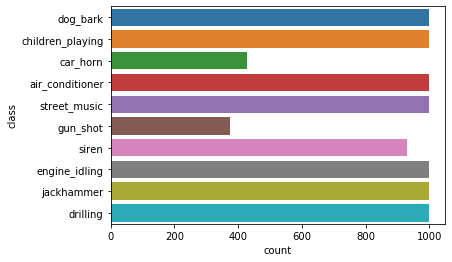

In [7]:
sns.countplot(y='class',data=df)

In [8]:
df['class'].value_counts()

street_music        1000
drilling            1000
dog_bark            1000
engine_idling       1000
children_playing    1000
jackhammer          1000
air_conditioner     1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

I have a relatively good dataset 7 classes have 1000 audio representation each.

Siren has 929, while car_horn has 429 and gun_shot has 374.

It is important for a dataset to be balanced this will ensure the ML algorithm is presented with a fair representation of each class. I will therefore use smote to balance the dataset later on in the project, after the features have been extracted

In [9]:
#calculating the length of each audio
df['length']= df['end']- df['start']
df['length']

0       0.317551
1       4.000000
2       4.000000
3       4.000000
4       4.000000
          ...   
8727    4.000000
8728    2.142545
8729    3.505983
8730    2.532098
8731    2.532099
Name: length, Length: 8732, dtype: float64

In [10]:
print(df['length'].mean()) #print the mean length
print(df['length'].max()) #print the maximum length
print(df['length'].min()) #print the minimum length

3.6079037445029747
4.000000000000028
0.05451700000000015


In [11]:
cls_df = df.groupby(['class', 'classID']).nunique()
cls_df.iloc[:, 0:0]

,
class,classID
air_conditioner,0
car_horn,1
children_playing,2
dog_bark,3
drilling,4
engine_idling,5
gun_shot,6
jackhammer,7
siren,8


### The above shows the 10 classes and their corresponding ClassID

## Visualisations of the audio files 
I will iterate through the metadata to pick 5 example from 5 distint classes as sample to visualize the dataset, I will ensure I pick a sound that its salience value is set to one to ensure that it has a good quality

In [12]:
unique_list = [] # create an empty list to hold unique class names
for row in range(len(df)): # loop through the dataframe
    if len(unique_list) == 5: # if length of unique_list is 5, then break out, we got our 5 classes
        break
    if df.iloc[row,][4] == 1: # check if salience is 1
        cls_name = df.iloc[row,][7] # set the class name
        if cls_name not in unique_list: # check if class name is not present in the list
            unique_list.append(cls_name) # append the unique class name in the list
            print(df.iloc[row,]) # print the required rows in series format

slice_file_name    100032-3-0-0.wav
fsID                         100032
start                           0.0
end                        0.317551
salience                          1
fold                              5
classID                           3
class                      dog_bark
length                     0.317551
Name: 0, dtype: object
slice_file_name    100263-2-0-117.wav
fsID                           100263
start                            58.5
end                              62.5
salience                            1
fold                                5
classID                             2
class                children_playing
length                            4.0
Name: 1, dtype: object
slice_file_name    100852-0-0-0.wav
fsID                         100852
start                           0.0
end                             4.0
salience                          1
fold                              5
classID                           0
class               air_conditioner


### I will go through the 5 samples listed above to visualise the audio in waveplot, MFCC and melspectrogram respectively

Data:  [-0.00347107 -0.00501926 -0.00465449 ... -0.00248442 -0.00154777
 -0.00035547]


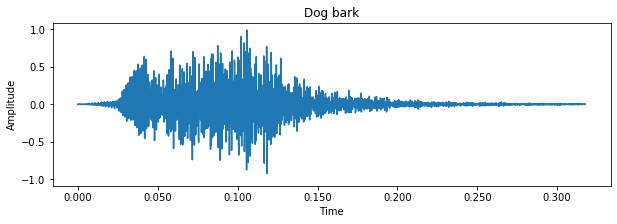

In [13]:
#Dog Bark
file_path = './audio/fold5/100032-3-0-0.wav'
data, sampling_rate = librosa.load(file_path)
print('Data: ',data)
plt.figure(figsize=(10, 3))
plt.title(label='Dog bark')
plt.xlabel('Time')
plt.ylabel('Amplitude')
librosa.display.waveshow(data, sr=sampling_rate)
ipd.Audio(data, rate=sampling_rate)

In [14]:
mfccs = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=40)
print(mfccs.shape)

(40, 14)


[Text(0.5, 1.0, 'MFCC - Dog bark')]

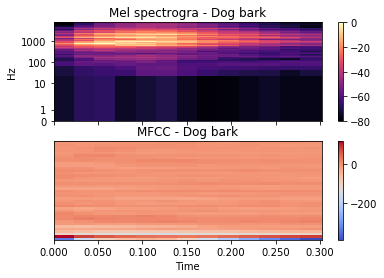

In [15]:
S = librosa.feature.melspectrogram(y=data, sr=sampling_rate, n_mels=128, fmax=8000)

fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogra - Dog bark')
ax[0].label_outer() 

img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC - Dog bark')

Data:  [ 0.00274057  0.00363865  0.00230643 ... -0.00752703 -0.00462696
  0.00097316]


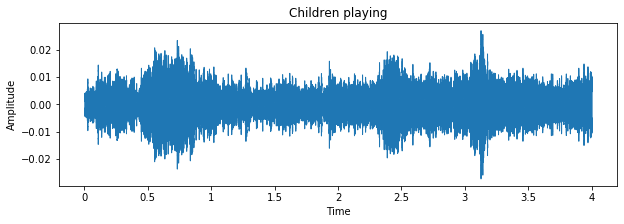

In [16]:
#Children playing
file_path = './audio/fold5/100263-2-0-117.wav'
data, sampling_rate = librosa.load(file_path)
print('Data: ',data)
plt.figure(figsize=(10, 3))
plt.title(label='Children playing')
plt.xlabel('Time')
plt.ylabel('Amplitude')
librosa.display.waveshow(data, sr=sampling_rate)
ipd.Audio(data, rate=sampling_rate)

In [17]:
mfccs = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=40)
print(mfccs.shape)

(40, 173)


[Text(0.5, 1.0, 'MFCC - Children playing')]

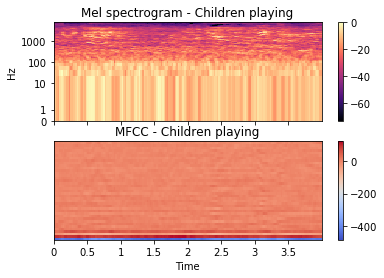

In [18]:
S = librosa.feature.melspectrogram(y=data, sr=sampling_rate, n_mels=128, fmax=8000)

fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram - Children playing')
ax[0].label_outer() 

img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC - Children playing')

Data:  [ 2.9103830e-11 -1.8553692e-10  1.1641532e-10 ...  7.3682994e-02
  1.6879775e-02  2.1070620e-02]


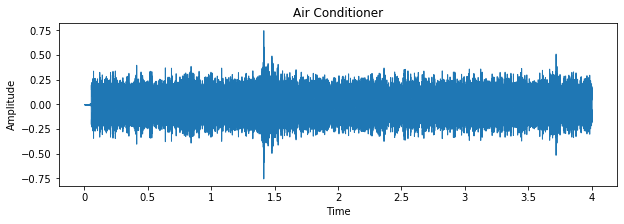

In [19]:
#Air Conditioner
file_path = './audio/fold5/100852-0-0-0.wav'
data, sampling_rate = librosa.load(file_path)
print('Data: ',data)
plt.figure(figsize=(10, 3))
plt.title(label='Air Conditioner')
plt.xlabel('Time')
plt.ylabel('Amplitude')
librosa.display.waveshow(data, sr=sampling_rate)
ipd.Audio(data, rate=sampling_rate)

In [20]:
mfccs = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=40)
print(mfccs.shape)

(40, 173)


[Text(0.5, 1.0, 'MFCC - Air Conditioner')]

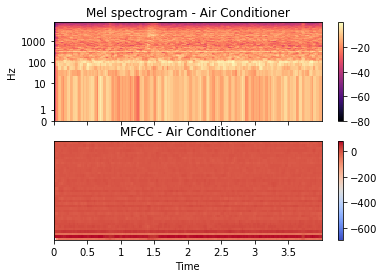

In [21]:
S = librosa.feature.melspectrogram(y=data, sr=sampling_rate, n_mels=128, fmax=8000)

fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram - Air Conditioner')
ax[0].label_outer() 

img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC - Air Conditioner')

Data:  [ 0.04671543  0.0810446   0.08158674 ... -0.00463078 -0.0046187
 -0.0049835 ]


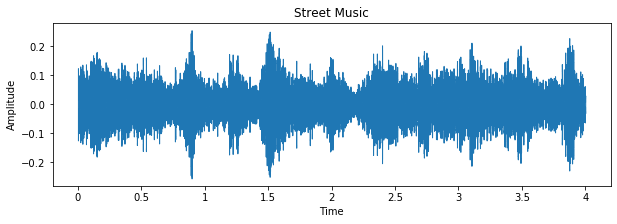

In [22]:
#Street music
file_path = './audio/fold7/101848-9-0-0.wav'
data, sampling_rate = librosa.load(file_path)
print('Data: ',data)
plt.figure(figsize=(10, 3))
plt.title(label='Street Music')
plt.xlabel('Time')
plt.ylabel('Amplitude')
librosa.display.waveshow(data, sr=sampling_rate)
ipd.Audio(data, rate=sampling_rate)

In [23]:
mfccs = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=40)
print(mfccs.shape)

(40, 173)


[Text(0.5, 1.0, 'MFCC - Street Music')]

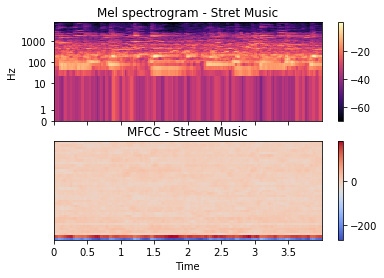

In [24]:
S = librosa.feature.melspectrogram(y=data, sr=sampling_rate, n_mels=128, fmax=8000)

fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram - Stret Music')
ax[0].label_outer() 

img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC - Street Music')

Data:  [-1.5772879e-05  5.2932650e-04  9.9616498e-04 ... -3.9790393e-13
  1.9895197e-13 -1.7763568e-14]


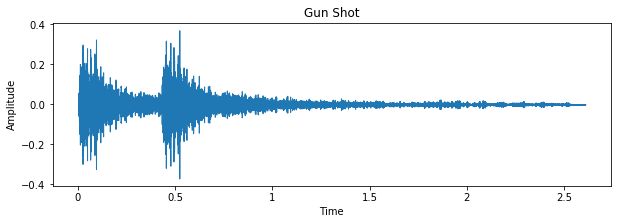

In [25]:
#Gun Shot
file_path = './audio/fold1/102305-6-0-0.wav'
data, sampling_rate = librosa.load(file_path)
print('Data: ',data)
plt.figure(figsize=(10, 3))
plt.title(label='Gun Shot')
plt.xlabel('Time')
plt.ylabel('Amplitude')
librosa.display.waveshow(data, sr=sampling_rate)
ipd.Audio(data, rate=sampling_rate)

In [26]:
mfccs = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=40)
print(mfccs.shape)

(40, 113)


[Text(0.5, 1.0, 'MFCC - Gun shot')]

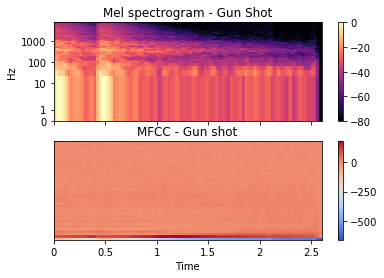

In [27]:
S = librosa.feature.melspectrogram(y=data, sr=sampling_rate, n_mels=128, fmax=8000)

fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram - Gun Shot')
ax[0].label_outer() 

img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC - Gun shot')

# Data Extraction

In [28]:
# Extracting MFCC's For every audio file in the dataset

audio_dataset_path='audio/'

def features_extractor(file):
    audio, sample_rate = librosa.load(file) 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40) # I'm using n_mfcc = 40 because I want to extract more features
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [29]:
from tqdm import tqdm

### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(df.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

3555it [00:48, 65.71it/s] /home/msc1/anaconda3/envs/Env-7146COMP/lib/python3.7/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1323
  f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"
8315it [01:52, 85.95it/s] /home/msc1/anaconda3/envs/Env-7146COMP/lib/python3.7/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1103
  f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"
8329it [01:53, 97.42it/s]/home/msc1/anaconda3/envs/Env-7146COMP/lib/python3.7/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1523
  f"n_fft={n_fft} is too large for input signal of length={y.shape[-1]}"
8732it [01:58, 73.98it/s]


In [30]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-211.93698, 62.581215, -122.813156, -60.74529...",dog_bark
1,"[-417.0052, 99.336624, -42.995586, 51.073326, ...",children_playing
2,"[-452.39316, 112.36253, -37.578075, 43.195866,...",children_playing
3,"[-406.47922, 91.1966, -25.043556, 42.784523, 1...",children_playing
4,"[-439.63873, 103.86223, -42.658787, 50.690285,...",children_playing


In [31]:
### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [32]:
X.shape

(8732, 40)

In [33]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

## Using smote to balance the extracted dataset

To view the class balance I'll convert '"y" to a dataframe solely for the purpose of using the method "value_count" subsequently i'll use "y" in it's numpy array format

In [34]:
# To see how the
y_pd = pd.DataFrame(y)# converting y to dataFrame so that i can perform the 'value_count'
y_pd.value_counts() #To show the class distribution before smote

air_conditioner     1000
children_playing    1000
dog_bark            1000
drilling            1000
engine_idling       1000
jackhammer          1000
street_music        1000
siren                929
car_horn             429
gun_shot             374
dtype: int64

In [35]:
from imblearn.over_sampling import SMOTE  # For balancing the data 

In [36]:
smote = SMOTE()
# Oversampling the train data
X,y = smote.fit_resample(X,y)

In [37]:
y_pd = pd.DataFrame(y)# converting y to dataFrame so that i can perform the 'value_count'
y_pd.value_counts() #To show the class distribution after smote

air_conditioner     1000
car_horn            1000
children_playing    1000
dog_bark            1000
drilling            1000
engine_idling       1000
gun_shot            1000
jackhammer          1000
siren               1000
street_music        1000
dtype: int64

### Label Encoding

The labels need to be encoded for our CNN algorithm, I need to translate this to be "one hot encoded" so our CNN can understand, Keras has an easy to use function for this

In [38]:
# Label Encoding
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y_encode=to_categorical(labelencoder.fit_transform(y))

In [39]:
y_encode

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

# Feature selection

My extracted audio dataset currently has 40 features, I will first use the 40 features to train my ML models then apply PCA on the features to reduce the dimension of the feature. Feature reduction can help reduce the computational time but care must be taken to ensure that accuracy of the model is not compromised

### Using PCA to reduce the feature to 20

In [40]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca.fit(X)

PCA(n_components=20)

In [41]:
X_pca = pca.transform(X)

In [42]:
X_pca

array([[-2.0078373e+01,  3.2149048e+01,  1.1954665e+02, ...,
        -8.0062973e-01,  1.6157986e+01, -7.3710504e+00],
       [ 1.8967688e+02,  1.9015886e+01,  1.2110123e+01, ...,
         3.2762196e+00, -4.5493656e-01, -4.4008565e+00],
       [ 2.2645612e+02,  9.7078705e+00,  8.9577227e+00, ...,
         7.4111671e+00,  1.7835692e+00, -1.6573331e+00],
       ...,
       [-1.2126895e+02, -5.5321606e+01,  4.8760174e+01, ...,
        -6.3779086e-02, -7.5355353e+00,  4.3420917e-01],
       [ 6.1837368e+01, -7.1450745e+01,  1.6117132e+01, ...,
         1.2700727e+00, -8.1605625e+00, -2.7532842e+00],
       [ 4.3373865e+02, -1.1598145e+01, -1.5989125e+01, ...,
        -5.7368932e+00,  5.1838775e+00, -1.3587656e+00]], dtype=float32)

In [43]:
X_pca.shape

(10000, 20)

# One Dimension convolutional neural network 

### I will first training  my CNN with the 40 features extrated using MFCC

In [44]:
X.shape

(10000, 40)

In [45]:
X[0].shape

(40,)

In [46]:
y_encode.shape

(10000, 10)

## Split Train/Test

I will divide the dataset into train and test dataset, the train set will be more than the test set because the more data the ML algorithm uses for training the better the outcome. The train dataset size is 80% and the test dataset size is 20%. The test will be used to estimate the model performance

In [47]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y_encode,test_size=0.2,random_state=0)

In [48]:
X_train.shape

(8000, 40)

In [49]:
y_train.shape

(8000, 10)

In [50]:
X_test.shape

(2000, 40)

In [51]:
y_test.shape

(2000, 10)

## Model Architecture

# 1 Dimension CNN

The model will have an input, output layer and two hidden layers.  The input layer and hidden layers will have activation function  relu  while the last will be softmax. When choosing hidden layer it should be kept in mind that increasing hidden layers would also increase the complexity of the model and choosing hidden layers such as 8, 9, or in two digits may sometimes lead to overfitting. Softmax is often used as the activation for the last layer of a classification network because the result could be interpreted as a probability distribution. Relu function applies the rectified linear unit activation function. With default values, this returns the standard ReLU activation: max(x, 0), the element-wise maximum of 0 and the input tensor.
The number of neuron in the final layer will be 10 since we have 10 class labels. The neurons in the other layers would need to be choosen based on experimentations, I will aim to choose the combination that gives the lowest loss and validation loss values, as well as the best accuracy for my dataset. 
I will use Adam optimizer, it is generally used as the default optimizer for most applications, because results of the Adam optimizer are generally better than every other optimization algorithm, have faster computation time, and require fewer parameters for tuning. 
Loss function will be categorical_crossentropy since we have a multiclass label, Mathematically, it is the preferred loss function under the inference framework of maximum likelihood

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [53]:
input_shape = X_train.shape[1:]
input_shape

(40,)

In [54]:
### No of classes
num_labels=y_encode.shape[1]
num_labels

10

In [55]:
model=Sequential()
###first layer
model.add(Dense(500,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(400))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

2023-04-18 07:50:12.358911: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-04-18 07:50:12.398157: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-18 07:50:12.398501: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.755GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2023-04-18 07:50:12.400449: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-04-18 07:50:12.416616: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-04-18 07:50:12.425258: I tensorflow/stream_executor/pl

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               20500     
_________________________________________________________________
activation (Activation)      (None, 500)               0         
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               200400    
_________________________________________________________________
activation_1 (Activation)    (None, 400)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               1

In [57]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [58]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
from tensorflow.keras.callbacks import EarlyStopping

num_epochs = 160
num_batch_size = 32
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history=model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test),  callbacks=[early_stop], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/160


2023-04-18 07:53:58.783359: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


250/250 [==============================] - 0s 2ms/step - loss: 5.7174 - accuracy: 0.1500 - val_loss: 2.1792 - val_accuracy: 0.1965
Epoch 2/160
250/250 [==============================] - 0s 1ms/step - loss: 2.2080 - accuracy: 0.2089 - val_loss: 2.0168 - val_accuracy: 0.2410
Epoch 3/160
250/250 [==============================] - 0s 1ms/step - loss: 2.0421 - accuracy: 0.2765 - val_loss: 1.8107 - val_accuracy: 0.3790
Epoch 4/160
250/250 [==============================] - 0s 1ms/step - loss: 1.8915 - accuracy: 0.3295 - val_loss: 1.6437 - val_accuracy: 0.4530
Epoch 5/160
250/250 [==============================] - 0s 1ms/step - loss: 1.7252 - accuracy: 0.4013 - val_loss: 1.5000 - val_accuracy: 0.5240
Epoch 6/160
250/250 [==============================] - 0s 1ms/step - loss: 1.5898 - accuracy: 0.4575 - val_loss: 1.3689 - val_accuracy: 0.5690
Epoch 7/160
250/250 [==============================] - 0s 1ms/step - loss: 1.4393 - accuracy: 0.5119 - val_loss: 1.2219 - val_accuracy: 0.6195
Epoch 8/160

In [59]:
eva_result=model.evaluate(X_test,y_test,verbose=0)
print("accuracy")
print(eva_result[1])

accuracy
0.9129999876022339


In [60]:
losses = pd.DataFrame(history.history)
losses.head()

,loss,accuracy,val_loss,val_accuracy
0,5.717417,0.150000,2.179180,0.1965
1,2.208037,0.208875,2.016795,0.2410
2,2.042084,0.276500,1.810694,0.3790
3,1.891462,0.329500,1.643712,0.4530
4,1.725171,0.401250,1.499986,0.5240


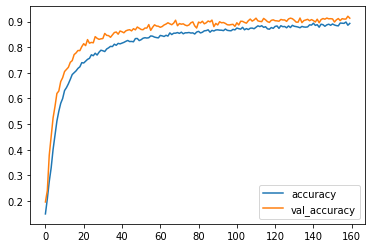

In [61]:
losses[['accuracy','val_accuracy']].plot()

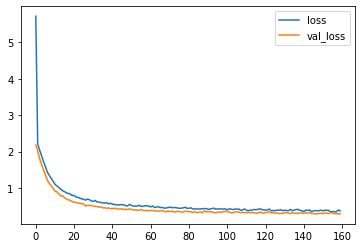

In [62]:
losses[['loss','val_loss']].plot()

In [63]:
pred = model.predict(X_test)
# one hot encoded multiclass labels so converting to argmax
arg_pred = np.argmax(pred, axis=1)
arg_true = np.argmax(y_test, axis=1)

In [64]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(arg_true, arg_pred))

[[177   0  11   1   0   0   1   0   0   1]
 [  0 186   2   0   0   0   0   1   0   4]
 [  3   0 183   4   1   1  10   0   0   5]
 [  0   0   9 170   0   0  15   0   4   4]
 [  0   0   5   0 190   0   0   7   0   2]
 [  0   0   6   1   0 182   0   1   0   2]
 [  0   0   4   1   0   0 190   0   0   0]
 [  1   0   0   0   0   0   0 204   0   5]
 [  0   0   9   3   0   0   3   0 187   0]
 [  1   0  35   3   1   4   1   2   0 157]]


In [65]:
print(classification_report(arg_true, arg_pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       191
           1       1.00      0.96      0.98       193
           2       0.69      0.88      0.78       207
           3       0.93      0.84      0.88       202
           4       0.99      0.93      0.96       204
           5       0.97      0.95      0.96       192
           6       0.86      0.97      0.92       195
           7       0.95      0.97      0.96       210
           8       0.98      0.93      0.95       202
           9       0.87      0.77      0.82       204

    accuracy                           0.91      2000
   macro avg       0.92      0.91      0.92      2000
weighted avg       0.92      0.91      0.91      2000



# SAVING my model in .h5 format 

In [66]:
model.save("my_model.h5")

## Training the CNN model with features reduced to 20 using PCA

In [67]:
model_pca=Sequential()
###first layer
model_pca.add(Dense(500,input_shape=(20,)))
model_pca.add(Activation('relu'))
model_pca.add(Dropout(0.5))
###second layer
model_pca.add(Dense(400))
model_pca.add(Activation('relu'))
model_pca.add(Dropout(0.5))
###third layer
model_pca.add(Dense(300))
model_pca.add(Activation('relu'))
model_pca.add(Dropout(0.5))

###final layer
model_pca.add(Dense(num_labels))
model_pca.add(Activation('softmax'))

In [68]:
model_pca.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 500)               10500     
_________________________________________________________________
activation_4 (Activation)    (None, 500)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 400)               200400    
_________________________________________________________________
activation_5 (Activation)    (None, 400)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 300)              

In [69]:
model_pca.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [70]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_pca,y_encode,test_size=0.2,random_state=0)

In [71]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 160
num_batch_size = 32
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history_pca=model_pca.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/160
250/250 [==============================] - 0s 2ms/step - loss: 4.6447 - accuracy: 0.2130 - val_loss: 1.9609 - val_accuracy: 0.3675
Epoch 2/160
250/250 [==============================] - 0s 1ms/step - loss: 2.0997 - accuracy: 0.2973 - val_loss: 1.7344 - val_accuracy: 0.4530
Epoch 3/160
250/250 [==============================] - 0s 1ms/step - loss: 1.8243 - accuracy: 0.3665 - val_loss: 1.5500 - val_accuracy: 0.5305
Epoch 4/160
250/250 [==============================] - 0s 1ms/step - loss: 1.6463 - accuracy: 0.4269 - val_loss: 1.3811 - val_accuracy: 0.5640
Epoch 5/160
250/250 [==============================] - 0s 1ms/step - loss: 1.5437 - accuracy: 0.4717 - val_loss: 1.2952 - val_accuracy: 0.5805
Epoch 6/160
250/250 [==============================] - 0s 1ms/step - loss: 1.4296 - accuracy: 0.5124 - val_loss: 1.2139 - val_accuracy: 0.6250
Epoch 7/160
250/250 [==============================] - 0s 1ms/step - loss: 1.3340 - accuracy: 0.5399 - val_loss: 1.1196 - val_accuracy: 0.6365

In [72]:
eva_result_pca=model_pca.evaluate(X_test,y_test,verbose=0)
print("accuracy")
print(eva_result_pca[1])

accuracy
0.8955000042915344


In [73]:
losses = pd.DataFrame(history_pca.history)
losses.head()

,loss,accuracy,val_loss,val_accuracy
0,4.644729,0.213000,1.960872,0.3675
1,2.099653,0.297250,1.734418,0.4530
2,1.824289,0.366500,1.550035,0.5305
3,1.646310,0.426875,1.381079,0.5640
4,1.543657,0.471750,1.295183,0.5805


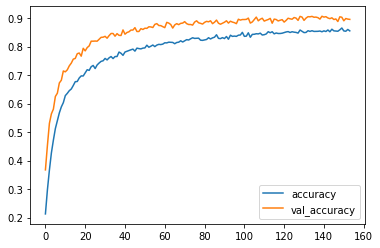

In [74]:
losses[['accuracy','val_accuracy']].plot()

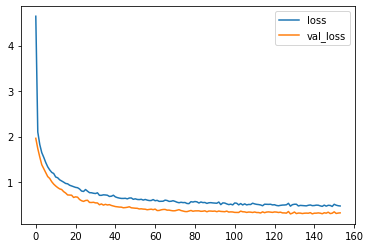

In [75]:
losses[['loss','val_loss']].plot()

In [76]:
pred = model_pca.predict(X_test)
# one hot encoded multiclass labels so converting to argmax
arg_pred = np.argmax(pred, axis=1)
arg_true = np.argmax(y_test, axis=1)

In [77]:
print(confusion_matrix(arg_true, arg_pred))

[[180   0   5   0   0   0   0   4   0   2]
 [  0 184   1   0   0   0   0   2   0   6]
 [  4   1 177   4   0   4   5   2   1   9]
 [  1   0  34 145   0   0   9   0   4   9]
 [  0   0   6   1 176   0   0  14   0   7]
 [  0   0   8   1   0 182   0   0   1   0]
 [  0   0   6   1   0   0 186   0   1   1]
 [  0   0   0   0   0   0   0 203   0   7]
 [  0   0   6   0   0   0   1   0 194   1]
 [  2   0  31   3   0   3   1   0   0 164]]


In [78]:
print(classification_report(arg_true, arg_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       191
           1       0.99      0.95      0.97       193
           2       0.65      0.86      0.74       207
           3       0.94      0.72      0.81       202
           4       1.00      0.86      0.93       204
           5       0.96      0.95      0.96       192
           6       0.92      0.95      0.94       195
           7       0.90      0.97      0.93       210
           8       0.97      0.96      0.96       202
           9       0.80      0.80      0.80       204

    accuracy                           0.90      2000
   macro avg       0.91      0.90      0.90      2000
weighted avg       0.91      0.90      0.90      2000



# Random Forest

Random forest, consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model's prediction, some of the hyperparameters that can be set includes:

n_estimators: this is used to set the number of trees needed in the random forest

max_depth: used to decide the depth to which a Tree can grow

min_samples_split:minimum number of samples required to split a node

min_samples_leaf:the number of samples in the leaf node

Finally confusion matrices and classification reports will be used for evaluation

### I'll first train the random forest model with the 40 features from the MFCC

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV  # find best hyperparameter  
from sklearn.metrics import confusion_matrix, classification_report # for model evaluation

In [80]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [81]:
# set up the parameter grid for grid search  to enable me select the best hyperparameters
param_grid = {
'n_estimators': [10, 50, 100, 200],
'max_depth': [None, 5, 10, 20],
'min_samples_split': [2, 5, 10],
'min_samples_leaf': [1, 2, 4]
}

# initialise the Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100)
# set up the grid search
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy')
# fit the grid search to the data
grid_search.fit(X_train, y_train)
# get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Parameters for RandomForestClassifier :", best_params)

Best Parameters for RandomForestClassifier : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [82]:
# initialise the Random Forest classifier with the best parameters
rfc = RandomForestClassifier(**best_params)
# fit the classifier to the training data
rfc.fit(X_train, y_train)
# make predictions on the test data
rfc_prediction = rfc.predict(X_test)
cm = confusion_matrix(y_test,rfc_prediction)

# Evaluation
print('Classification Report')
print(classification_report(y_test,rfc_prediction))

print('Confusion Matrix')
print(cm)

Classification Report
                  precision    recall  f1-score   support

 air_conditioner       0.99      0.97      0.98       191
        car_horn       0.97      0.97      0.97       193
children_playing       0.81      0.88      0.84       207
        dog_bark       0.91      0.82      0.86       202
        drilling       0.95      0.90      0.92       204
   engine_idling       0.95      0.97      0.96       192
        gun_shot       0.99      0.97      0.98       195
      jackhammer       0.92      0.97      0.94       210
           siren       0.93      0.97      0.95       202
    street_music       0.83      0.84      0.84       204

        accuracy                           0.92      2000
       macro avg       0.93      0.92      0.92      2000
    weighted avg       0.92      0.92      0.92      2000

Confusion Matrix
[[185   0   1   0   0   0   0   3   0   2]
 [  0 187   1   0   1   0   0   1   0   3]
 [  1   1 182   6   2   2   0   0   2  11]
 [  0   3  14 165

In [83]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape # (n_samples, n_classes)


(2000, 10)

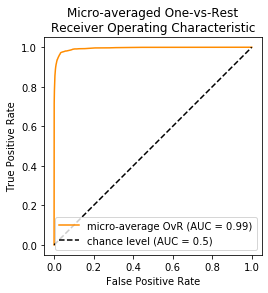

In [84]:
y_score = rfc.fit(X_train, y_train).predict_proba(X_test)
RocCurveDisplay.from_predictions(
y_onehot_test.ravel(),
y_score.ravel(),
name="micro-average OvR",
color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [85]:
y_score = np.clip(y_score,1e-10,None)
loss=-np.mean(y_onehot_test*np.log(y_score))
loss

0.056584511152455864

# Random Forest with PCA Features

In [86]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_pca,y,test_size=0.2,random_state=0)

In [87]:
# set up the parameter grid for grid search
param_grid = {
'n_estimators': [10, 50, 100, 200],
'max_depth': [None, 5, 10, 20],
'min_samples_split': [2, 5, 10],
'min_samples_leaf': [1, 2, 4]
}

# initialise the Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100)
# set up the grid search
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy')
# fit the grid search to the data
grid_search.fit(X_train, y_train)
# get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Parameters for RandomForestClassifier :", best_params)

Best Parameters for RandomForestClassifier : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [88]:
# initialise the Random Forest classifier with the best parameters
rfc = RandomForestClassifier(**best_params)
# fit the classifier to the training data
rfc.fit(X_train, y_train)
# make predictions on the test data
rfc_prediction = rfc.predict(X_test)
cm = confusion_matrix(y_test,rfc_prediction)

# Evaluation
print('Classification Report')
print(classification_report(y_test,rfc_prediction))

print('Confusion Matrix')
print(cm)

Classification Report
                  precision    recall  f1-score   support

 air_conditioner       0.96      0.96      0.96       191
        car_horn       0.99      0.96      0.98       193
children_playing       0.83      0.83      0.83       207
        dog_bark       0.93      0.86      0.89       202
        drilling       0.95      0.89      0.92       204
   engine_idling       0.96      0.98      0.97       192
        gun_shot       0.98      0.98      0.98       195
      jackhammer       0.90      0.97      0.93       210
           siren       0.95      0.97      0.96       202
    street_music       0.82      0.85      0.84       204

        accuracy                           0.92      2000
       macro avg       0.93      0.92      0.93      2000
    weighted avg       0.92      0.92      0.92      2000

Confusion Matrix
[[183   0   1   0   0   0   0   4   0   3]
 [  1 185   0   0   0   0   0   2   0   5]
 [  5   0 172   6   4   1   1   1   6  11]
 [  0   0  13 174

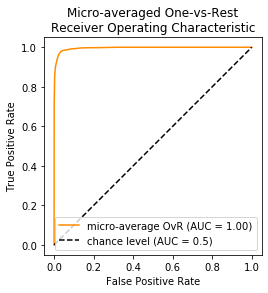

In [89]:
y_score = rfc.fit(X_train, y_train).predict_proba(X_test)
RocCurveDisplay.from_predictions(
y_onehot_test.ravel(),
y_score.ravel(),
name="micro-average OvR",
color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [90]:
y_score = np.clip(y_score,1e-10,None)
loss=-np.mean(y_onehot_test*np.log(y_score))
loss

0.05210749932052771

# Inference

## Load the model that was previously saved

I used unseen audio sounds to test the model and it perfomed well

In [91]:
from tensorflow import keras
saved_model = keras.models.load_model("my_model.h5")

In [92]:
filename="sounds/dog_barking.wav"
audio, sample_rate = librosa.load(filename) 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40) # I'm using n_mfcc = 40 because I want to extract more features
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_label=saved_model.predict_classes(mfccs_scaled_features)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

[-3.9049402e+02  1.1954937e+02 -1.8282722e+01 -1.8389553e+01
 -4.4908915e+00 -1.0762940e+01 -1.2764085e+01  7.6573497e-01
 -1.2004446e+01 -2.9721069e+00  7.1187935e+00  9.4508915e+00
  1.3947540e+01  1.1218645e+01  1.0438324e+01  2.9898632e+00
 -6.8481817e+00  1.2972575e+00 -3.0498097e+00  2.8990920e+00
 -3.6028702e+00  1.0434518e+00  6.2925130e-02  6.7683644e+00
  1.0594019e+00  3.5829444e+00  5.5970898e+00 -1.6847514e+00
  3.7541753e-01  1.1498706e+00  1.7418511e+00  4.0257540e+00
 -1.7146598e+00  4.7304103e-01  1.3691014e+00  2.5950488e-01
  1.7695769e+00 -7.2825354e-01  1.9022213e+00  7.4673425e-03]
[[-3.9049402e+02  1.1954937e+02 -1.8282722e+01 -1.8389553e+01
  -4.4908915e+00 -1.0762940e+01 -1.2764085e+01  7.6573497e-01
  -1.2004446e+01 -2.9721069e+00  7.1187935e+00  9.4508915e+00
   1.3947540e+01  1.1218645e+01  1.0438324e+01  2.9898632e+00
  -6.8481817e+00  1.2972575e+00 -3.0498097e+00  2.8990920e+00
  -3.6028702e+00  1.0434518e+00  6.2925130e-02  6.7683644e+00
   1.0594019e+00 

array(['dog_bark'], dtype='<U16')

In [93]:
filename="sounds/children_playing.wav"
audio, sample_rate = librosa.load(filename) 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40) # I'm using n_mfcc = 40 because I want to extract more features
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_label=saved_model.predict_classes(mfccs_scaled_features)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

[-2.8887408e+02  1.0373005e+02  5.4493570e+00  2.4906622e+01
  7.3467946e-01 -2.1880751e+00 -7.1437163e+00 -1.8606718e+00
 -4.6344800e+00  1.0761232e+00 -2.8419325e+00  5.8024430e+00
 -1.6075549e-01  2.2630172e+00 -3.8221115e-01  5.3199321e-01
 -5.1863208e+00 -6.0360885e-01 -5.5911260e+00  1.6108094e+00
  7.3477417e-02  5.1683273e+00  5.2438378e-01 -2.3057294e-01
 -4.6339784e+00 -3.5382256e-02 -5.2793775e+00 -6.0683411e-02
 -4.0105271e+00  2.2445393e+00 -9.5555589e-02  3.6685002e+00
 -1.1594602e+00  2.0902593e+00 -1.8351650e+00  2.0506873e+00
  2.5270042e-01  4.5726700e+00  6.6434383e-02  2.2288775e+00]
[[-2.8887408e+02  1.0373005e+02  5.4493570e+00  2.4906622e+01
   7.3467946e-01 -2.1880751e+00 -7.1437163e+00 -1.8606718e+00
  -4.6344800e+00  1.0761232e+00 -2.8419325e+00  5.8024430e+00
  -1.6075549e-01  2.2630172e+00 -3.8221115e-01  5.3199321e-01
  -5.1863208e+00 -6.0360885e-01 -5.5911260e+00  1.6108094e+00
   7.3477417e-02  5.1683273e+00  5.2438378e-01 -2.3057294e-01
  -4.6339784e+00 

array(['children_playing'], dtype='<U16')

In [94]:
filename="sounds/drilling.wav"
audio, sample_rate = librosa.load(filename) 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40) # I'm using n_mfcc = 40 because I want to extract more features
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_label=saved_model.predict_classes(mfccs_scaled_features)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

[-93.21278     52.912006    25.76499      1.5710272   -5.710599
  14.152807   -16.843117    12.248266   -11.978619    10.704815
  -8.492168     6.1268945   -3.328445    -8.1356      -4.4586062
  -4.044615     2.8773036   -2.9395328   -6.6101437    7.58362
  -7.3104663    4.034537    -4.321166     4.5032263   -0.4976207
   3.2327585   -2.0618708    0.55676484  -1.4915575   -1.7794293
  -1.7694769   -1.9620268   -4.6373124   -0.26604903  -4.4953837
   2.0640197   -3.0373502   -1.189358    -0.36424664  -0.62544566]
[[-93.21278     52.912006    25.76499      1.5710272   -5.710599
   14.152807   -16.843117    12.248266   -11.978619    10.704815
   -8.492168     6.1268945   -3.328445    -8.1356      -4.4586062
   -4.044615     2.8773036   -2.9395328   -6.6101437    7.58362
   -7.3104663    4.034537    -4.321166     4.5032263   -0.4976207
    3.2327585   -2.0618708    0.55676484  -1.4915575   -1.7794293
   -1.7694769   -1.9620268   -4.6373124   -0.26604903  -4.4953837
    2.0640197   -3.03735

array(['drilling'], dtype='<U16')

# Discussion

I trained the audio dataset with both CNN and Radom Forest, the two Models performed well. CNN had an accuracy of 0.90 and Random Forest had an accuracy of 0.92. The use of grid search in Random forest must have helped in selecting the best hyper-parameters needed for a good model. I used 160 epoch and also made use of early-stopping to ensure that the CNN does not over train, this is to prevent overfitting .I also reduced the features to twenty components using PCA. However CNN was affected and its accuracy value dropped  to 0.89 this means that a reduced feature set was not efficient. Interestingly Radom Forest maintained almost the same result even after the features were reduced. It therefore means if you have limited hardware resources it might be better to use Random Forest since you can still get good results after reducing the features.
Since the training was done on a balaned dataset after applying smote, we can reckon with accuracy for measure of our model performance. Based on the accuracy and loss after training the dataset on CNN and Random Forest models my preferred model is Random Forest.
